In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)

In [2]:
data = pd.read_csv('C:\\Users\\raibe\\Desktop\\Thesis Code\\datasets\\data batches\\ndb1.csv')

In [3]:
data = data.drop(["label", "default", "current_year"], axis=1)

In [4]:
data.head()

,time,payoff,int.rate,orig.upb,fico.score,dti.r,ltv.r,bal.repaid,t.act.12m,t.del.30d.12m,...,ppi.o.FRMA,equity.est,hpi.st.log12m,hpi.r.st.us,hpi.r.zip.st,st.unemp.r12m,st.unemp.r3m,TB10Y.r12m,T10Y3MM,T10Y3MM.r12m
0,20,1,7.00,63000,657,26,79,2.078556,11,1,...,1.01,32293.92,0.146144,1.110008,1.234804,-0.7,-0.1,0.39,3.41,0.58
1,7,1,7.00,132000,647,33,80,0.583939,11,1,...,-0.18,46221.55,0.146154,1.078726,1.668582,0.9,0.1,-0.86,2.24,0.15
2,9,1,6.25,152000,761,29,80,0.871974,12,0,...,0.32,42039.07,0.093969,1.054944,1.006483,0.6,0.0,0.19,3.50,0.86
3,31,1,7.00,50000,758,24,37,3.386060,12,0,...,-0.23,106211.90,0.033797,0.968266,1.407201,2.1,0.9,-1.07,2.78,3.23
4,18,1,6.75,181000,653,29,55,1.415833,11,1,...,-0.06,163735.70,0.017066,0.893576,1.507073,0.5,0.0,-0.67,3.08,0.11


In [5]:
data.columns

Index(['time', 'payoff', 'int.rate', 'orig.upb', 'fico.score', 'dti.r',
       'ltv.r', 'bal.repaid', 't.act.12m', 't.del.30d.12m', 't.del.60d.12m',
       'hpi.st.d.t.o', 'hpi.zip.o', 'hpi.zip.d.t.o', 'ppi.c.FRMA',
       'TB10Y.d.t.o', 'FRMA30Y.d.t.o', 'ppi.o.FRMA', 'equity.est',
       'hpi.st.log12m', 'hpi.r.st.us', 'hpi.r.zip.st', 'st.unemp.r12m',
       'st.unemp.r3m', 'TB10Y.r12m', 'T10Y3MM', 'T10Y3MM.r12m'],
      dtype='object')

In [6]:
df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [7]:
cols_standardize = ['int.rate', 'orig.upb', 'fico.score', 'dti.r',
       'ltv.r', 'bal.repaid','hpi.st.d.t.o', 'hpi.zip.o', 'hpi.zip.d.t.o', 'ppi.c.FRMA',
       'TB10Y.d.t.o', 'FRMA30Y.d.t.o', 'ppi.o.FRMA', 'equity.est',
       'hpi.st.log12m', 'hpi.r.st.us', 'hpi.r.zip.st', 'st.unemp.r12m',
       'st.unemp.r3m', 'TB10Y.r12m', 'T10Y3MM', 'T10Y3MM.r12m']
       
cols_leave = ['t.act.12m', 't.del.30d.12m', 't.del.60d.12m']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [8]:
num_durations = 25

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['payoff'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [9]:
in_features = x_train.shape[1]
num_nodes = [256, 256, 256, 256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1


#in_features = x_train.shape[1]
#num_nodes = [32, 32]
#out_features = labtrans.out_features
#batch_norm = True
#dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [10]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

C:\Users\raibe\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [12]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 3.0062,	val_loss: 2.8737
1:	[1s / 2s],		train_loss: 1.5626,	val_loss: 2.0408
2:	[1s / 3s],		train_loss: 1.4236,	val_loss: 1.3345
3:	[1s / 4s],		train_loss: 1.2736,	val_loss: 1.2453
4:	[1s / 5s],		train_loss: 1.2925,	val_loss: 1.2550
5:	[1s / 6s],		train_loss: 1.2792,	val_loss: 1.1484
6:	[1s / 8s],		train_loss: 1.1358,	val_loss: 1.5761
7:	[1s / 9s],		train_loss: 1.1256,	val_loss: 1.4142
8:	[1s / 10s],		train_loss: 1.1310,	val_loss: 1.2252
9:	[1s / 11s],		train_loss: 1.1305,	val_loss: 1.3150
10:	[1s / 13s],		train_loss: 1.0658,	val_loss: 1.3537
11:	[1s / 14s],		train_loss: 1.0153,	val_loss: 1.0851
12:	[1s / 16s],		train_loss: 1.1041,	val_loss: 1.8728
13:	[1s / 17s],		train_loss: 1.1327,	val_loss: 1.3022
14:	[1s / 18s],		train_loss: 1.0197,	val_loss: 1.0002
15:	[1s / 20s],		train_loss: 0.9883,	val_loss: 1.3120
16:	[1s / 21s],		train_loss: 0.9299,	val_loss: 1.0966
17:	[1s / 22s],		train_loss: 0.9534,	val_loss: 1.2993
18:	[1s / 24s],		train_loss: 1.0264,	val_loss:

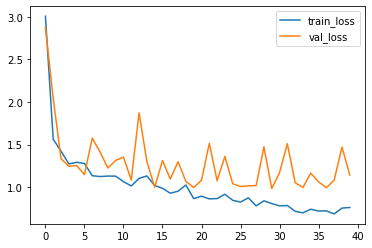

In [13]:
_ = log.plot()

In [14]:
log.to_pandas().val_loss.min()

0.984080970287323

In [15]:
model.score_in_batches(val)

{'loss': 0.984080970287323}

In [16]:
surv = model.predict_surv_df(x_test)

In [17]:
surv = model.interpolate(10).predict_surv_df(x_test)

In [18]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [19]:
ev.concordance_td()

0.9530456488825401